In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

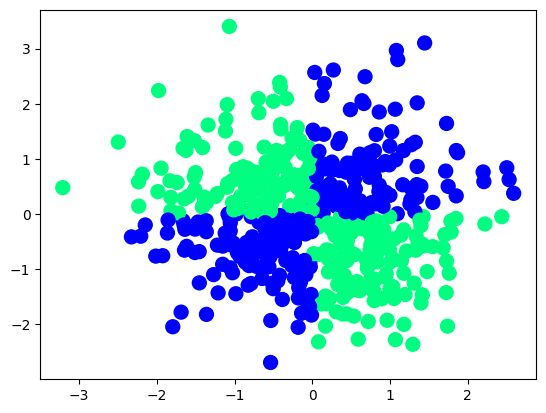

In [2]:
np.random.seed(13)
X = np.random.randn(500, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap="winter");

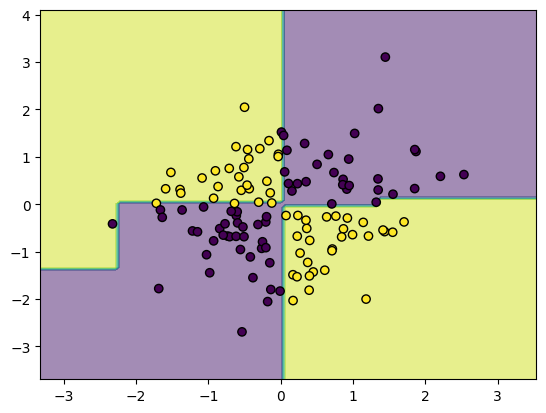

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)
clf = DecisionTreeClassifier(random_state=13)
clf.fit(X_train, y_train)

display = DecisionBoundaryDisplay.from_estimator(
    clf,
    X_test,
    response_method="predict",
    alpha=0.5,
)
display.ax_.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor="black")

In [252]:
clf = DecisionTreeClassifier(criterion="gini", max_depth=10)

In [253]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.25, stratify=wine.target)

In [254]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [255]:
accuracy_score(y_test, clf.predict(X_test))

0.9111111111111111

In [256]:
f1_score(y_test, clf.predict(X_test), average="weighted")

np.float64(0.9111688311688312)

In [257]:
roc_auc_score(y_test, clf.predict_proba(X_test), multi_class="ovo")

np.float64(0.9305555555555555)

In [258]:
np.unique(y_train)

array([0, 1, 2])

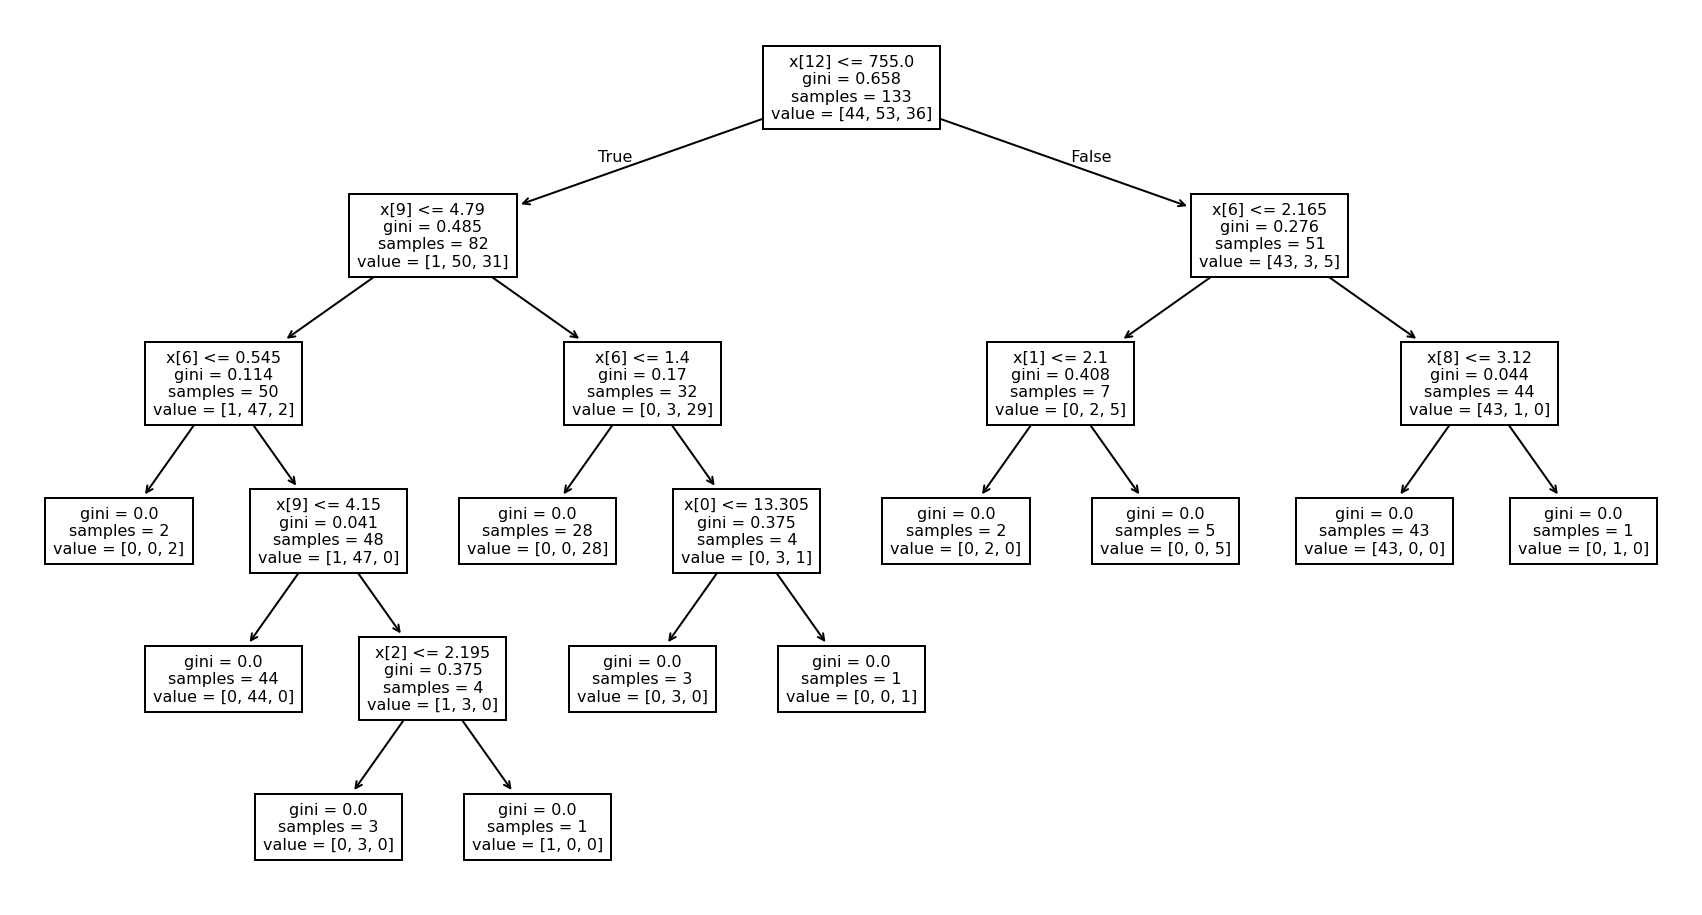

In [259]:
plt.figure(figsize=(15, 8), dpi=144)
plot_tree(clf, fontsize=8);

### Реализация дерева решений

### Энтропия
$$
H(p) = - \sum p \log(p)
$$

### Критерий Джини
$$
H(p) = \sum p (1 - p) = 1 - \sum p^2
$$

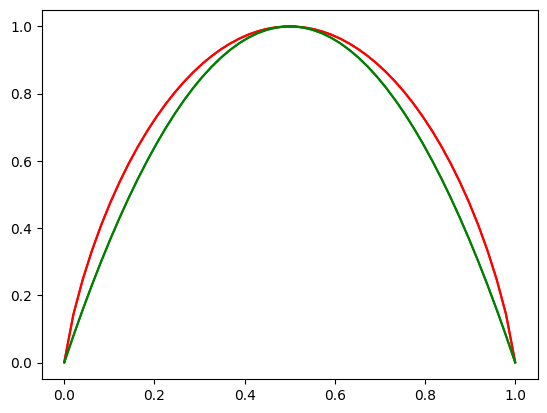

In [278]:
p = np.linspace(1e-4, 1 - 1e-4)
p = np.array([p, 1 - p]).T

plt.plot(p, [-(p * np.log2(p)).sum() for p in p], color="red")
plt.plot(p, [2 * (p * (1 - p)).sum() for p in p], color="green")

In [261]:
def entropy(y):
    p = np.bincount(y) / len(y)
    p = p[p > 0]
    return -(p * np.log(p)).sum()


def gini(y):
    p = np.bincount(y) / len(y)
    return (p * (1 - p)).sum()

In [262]:
class MyDecisionTree:
    NON_LEAF = 0
    LEAF = 1

    CRITERIONS = {
        "entropy": entropy,
        "gini": gini,
    }

    def __init__(self, criterion="entropy", max_depth=None, min_samples_split=2):
        self.criterion = criterion
        self.max_depth = max_depth
        self._tree = {}
        self.num_classes = -1
        self.min_samples_split = min_samples_split
        self._feature_importances = None

    def fit(self, X_train, y_train):
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        self.num_classes = np.unique(y_train).shape[0]
        self._feature_importances = np.zeros(X_train.shape[1])
        self._fit_node(X_train, y_train, 0, 0)

    def _get_criterion_score(self, y_left, y_right, criterion):
        H_left = criterion(y_left)
        R_left = len(y_left) / (len(y_left) + len(y_right))

        H_right = criterion(y_right)
        R_right = len(y_right) / (len(y_left) + len(y_right))
        return R_left * H_left + R_right * H_right

    def _get_best_split(self, X, y):
        best_feature = -1
        best_threshold = -1
        best_score = np.inf

        try:
            criterion = self.CRITERIONS[self.criterion]
        except KeyError:
            raise RuntimeError("invalid criterion type")

        H = criterion(y)
        
        for feature in range(X.shape[1]):
            column = X[:, feature]
            unique_values = np.unique(column)
            for value in unique_values:
                left_mask = column <= value
                right_mask = column > value

                y_left = y[left_mask]
                y_right = y[right_mask]
                score = self._get_criterion_score(y_left, y_right, criterion)
                if score < best_score:
                    best_score = score
                    best_feature = feature
                    best_threshold = value

        self._feature_importances[best_feature] += H - best_score
        return best_feature, best_threshold

    def _fit_node(self, X, y, node_id, depth):
        if (
            np.all(y == y[0])
            or (self.max_depth is not None and depth == self.max_depth - 1)
            or X_train.shape[0] <= self.min_samples_split
        ):
            values, counts = np.unique(y, return_counts=True)
            pred = values[np.argmax(counts)]
            probs = np.zeros(self.num_classes)
            for value, count in zip(values, counts):
                probs[value] = count
            probs /= len(y)
            self._tree[node_id] = (self.LEAF, pred, probs)
            return

        feature, threshold = self._get_best_split(X, y)
        self._tree[node_id] = (self.NON_LEAF, feature, threshold)

        left_mask = X[:, feature] <= threshold
        X_left = X[left_mask]
        y_left = y[left_mask]

        right_mask = X[:, feature] > threshold
        X_right = X[right_mask]
        y_right = y[right_mask]

        self._fit_node(X_left, y_left, 2 * node_id + 1, depth + 1)
        self._fit_node(X_right, y_right, 2 * node_id + 2, depth + 1)

    def _predict_single(self, x, node_id):
        node = self._tree[node_id]
        if node[0] == self.LEAF:
            return node[1:]

        _, feature, threshold = node
        if x[feature] <= threshold:
            return self._predict_single(x, 2 * node_id + 1)
        else:
            return self._predict_single(x, 2 * node_id + 2)

    def predict(self, X_test):
        return np.array([self._predict_single(x, 0)[0] for x in X_test])

    def predict_proba(self, X_test):
        return np.array([self._predict_single(x, 0)[1] for x in X_test])

In [265]:
my_tree = MyDecisionTree(criterion="gini", max_depth=10)
my_tree.fit(X_train, y_train)

In [266]:
my_tree._tree

{0: (0, 12, np.float64(750.0)),
 1: (0, 9, np.float64(4.68)),
 3: (0, 6, np.float64(0.52)),
 7: (1, np.int64(2), array([0., 0., 1.])),
 8: (0, 9, np.float64(3.94)),
 17: (1, np.int64(1), array([0., 1., 0.])),
 18: (0, 0, np.float64(13.03)),
 37: (1, np.int64(1), array([0., 1., 0.])),
 38: (1, np.int64(0), array([1., 0., 0.])),
 4: (0, 6, np.float64(1.39)),
 9: (1, np.int64(2), array([0., 0., 1.])),
 10: (0, 0, np.float64(13.11)),
 21: (1, np.int64(1), array([0., 1., 0.])),
 22: (1, np.int64(2), array([0., 0., 1.])),
 2: (0, 6, np.float64(2.14)),
 5: (0, 1, np.float64(1.61)),
 11: (1, np.int64(1), array([0., 1., 0.])),
 12: (1, np.int64(2), array([0., 0., 1.])),
 6: (0, 0, np.float64(12.47)),
 13: (1, np.int64(1), array([0., 1., 0.])),
 14: (1, np.int64(0), array([1., 0., 0.]))}

In [267]:
accuracy_score(y_test, my_tree.predict(X_test))

0.9333333333333333

In [268]:
f1_score(y_test, my_tree.predict(X_test), average="weighted")

np.float64(0.9327020202020202)

In [269]:
roc_auc_score(y_test, my_tree.predict_proba(X_test), multi_class="ovo")

np.float64(0.9444444444444445)

In [270]:
pd.DataFrame({
    "features": wine["feature_names"],
    "my_tree": my_tree._feature_importances,
    "sklearn": clf.feature_importances_,
}).sort_values(by="sklearn", ascending=False)

,features,my_tree,sklearn
12,proline,0.253534,0.385024
9,color_intensity,0.358609,0.332058
6,flavanoids,0.379981,0.193721
1,malic_acid,0.408163,0.032624
8,proanthocyanins,0.000000,0.022318
2,ash,0.000000,0.017127
0,alcohol,0.794421,0.017127
4,magnesium,0.000000,0.000000
3,alcalinity_of_ash,0.000000,0.000000
7,nonflavanoid_phenols,0.000000,0.000000


### Случайный лес

In [216]:
from sklearn.ensemble import RandomForestClassifier

In [272]:
rf = RandomForestClassifier(max_depth=10, criterion="gini", n_estimators=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
# accuracy_score(y_test, y_pred)
roc_auc_score(y_test, rf.predict_proba(X_test), multi_class="ovo")

np.float64(0.9932098765432098)

In [273]:
class MyRandomForest:
    def __init__(self, n_estimators=10, max_samples=None, *args):
        self.args = args
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.estimators = [None] * n_estimators

    def fit(self, X_train, y_train):
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        self.estimators = [MyDecisionTree(*self.args) for _ in range(self.n_estimators)]
        self.selected_features = []
        self.feature_importances = np.zeros(X_train.shape[1])
        for estimator in self.estimators:
            if self.max_samples is None:
                size = X_train.shape[0]
            else:
                size = int(self.max_samples * X_train.shape[0])
            ids_sample = np.random.choice(X_train.shape[0], size=size)
            feature = np.random.choice(X_train.shape[1], replace=False, size=int(np.sqrt(X_train.shape[1])))
            self.selected_features.append(feature)
            estimator.fit(X_train[ids_sample][:, feature], y_train[ids_sample])
            self.feature_importances[feature] += estimator._feature_importances / self.n_estimators

    def predict_proba(self, X_test):
        return np.mean([
            estimator.predict_proba(X_test[:, sf])
            for estimator, sf in zip(self.estimators, self.selected_features)
        ], axis=0)

In [274]:
my_rf = MyRandomForest(n_estimators=10)
my_rf.fit(X_train, y_train)

In [275]:
roc_auc_score(y_test, my_rf.predict_proba(X_test), multi_class="ovo")

np.float64(0.9950617283950617)

In [276]:
pd.DataFrame({
    "features": wine["feature_names"],
    "my_rf": my_rf.feature_importances,
    "sklearn": rf.feature_importances_,
}).sort_values(by="my_rf", ascending=False)

,features,my_rf,sklearn
6,flavanoids,0.857667,0.045247
7,nonflavanoid_phenols,0.623542,0.009286
3,alcalinity_of_ash,0.493595,0.085334
4,magnesium,0.474788,0.028729
12,proline,0.455655,0.142241
1,malic_acid,0.447043,0.046566
2,ash,0.414203,0.016301
11,od280/od315_of_diluted_wines,0.292821,0.178776
0,alcohol,0.275020,0.197330
8,proanthocyanins,0.249405,0.019331
